# A2 - Linear Regression and Classification

In [77]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
from google.colab import drive

import numpy as np
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Logistic Regression & Multiclass Regression models

In [78]:
def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))
    return J

### Linear Regression

In [79]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh

### Logistic regression

In [80]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.01, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.best_w = None

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad                         # size D

    def cost_fn(self, x, y):
        z = np.dot(x, self.w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies
        return J

    def fit(self, x, y, x_valid=None, y_valid=None):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
            x_valid = np.column_stack([x_valid, np.ones(x_valid.shape[0])]) if x_valid is not None else None
            self.w = np.zeros(x.shape[1])  # Adding one more weight for the bias term
            self.best_w = np.zeros(x.shape[1])

        N, D = x.shape
        self.w = np.zeros(D)
        self.w = self.w.reshape(-1, 1)
        self.best_w = np.zeros(D)
        self.best_w = self.w.reshape(-1, 1)
        g = np.inf
        t = 0
        loss_train = []
        validation_accuracies = []
        losses_valid = []

        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1
            ce = self.cost_fn(x, y)
            loss_train.append(ce)

            if x_valid is not None and y_valid is not None:
                loss_valid = self.cost_fn(x_valid, y_valid)
                losses_valid.append(loss_valid)
                y_valid_pred = self.predict(x_valid, use_best_w=False)
                val_accuracy = self.evaluate(y_valid_pred, y_valid)
                if val_accuracy > max(validation_accuracies, default=float('-inf')):
                    self.best_w = self.w.copy()
                validation_accuracies.append(val_accuracy)


            if self.verbose:
                print(f'Iteration {t}, Cost: {ce}, Validation Accuracy: {val_accuracy if x_valid is not None else "N/A"}')

        if self.verbose:
            print(f'Terminated after {t} iterations, with gradient norm: {np.linalg.norm(g)}')
            print(f'Final weights: \n{self.w}')

        return loss_train, losses_valid, validation_accuracies, x


    def predict(self, x, use_best_w=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]

        if self.add_bias and use_best_w:
            x = np.column_stack([x,np.ones(Nt)])

        if not use_best_w:
          yh = logistic(np.dot(x,self.w))
        else:
          yh = logistic(np.dot(x,self.best_w))

        return yh


    def evaluate(self, y_pred, y):
        predicted_labels = (y_pred >= 0.5).astype(int)
        true_labels = y.astype(int)
        accuracy = np.mean(predicted_labels == true_labels)
        return accuracy


### Multinomial Logistic

In [81]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses, verbose=True):
        np.random.seed(4)
        self.W = np.random.rand(nFeatures, nClasses)
        self.verbose = verbose

    def predict(self, X, use_best_w=False):
        if self.best_W is None or not use_best_w:
          y_pred = np.exp(np.matmul(X, self.W))
        else:
          y_pred = np.exp(np.matmul(X, self.best_W))

        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)


    def gradient(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)


    def ce(self, X, y):
        epsilon = 1e-8  # Small constant
        return -np.sum(y * np.log(self.predict(X) + epsilon))


    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.01, niter=100):
        tol = 1e-5
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        val_accuracies = np.zeros(niter)
        self.best_W = None

        for i in range(niter):
            gradient = self.gradient(X, y)
            self.W -= lr * gradient
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train

            if X_valid is not None and y_valid is not None:
                validation_prediction = self.predict(X_valid, use_best_w=False)
                accuracy = self.evaluate(y_valid, validation_prediction)
                if accuracy > max(val_accuracies, default=float('-inf')):
                    self.best_W = self.W.copy()
                val_accuracies[i] = accuracy

                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                if self.verbose:
                    print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                if self.verbose:
                    print(f"iter {i}: {loss_train:.3f}")

            if i > 0 and abs(losses_train[i] - losses_train[i-1]) < tol:
                print(f"Converged at iteration {i}")
                break
            if np.linalg.norm(gradient) < tol:
                print(f"Gradient norm is small, stopping at iteration {i}")
                break

        return losses_train, losses_valid, val_accuracies


    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4
                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.gradient(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


    def evaluate(self, y_pred, y):
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(predicted_labels == true_labels)
        return accuracy


# Breast Cancer Dataset (Binary Classification)

## Breast Cancer - Task 1 - Simple linear regression

In [82]:
# Fetch dataset
breast_cancer_df = fetch_ucirepo(id=17)

In [83]:
# Data features
bc_X = breast_cancer_df.data.features

# Convert targets to a pandas DataFrame
bc_y = breast_cancer_df.data.targets.copy()
bc_y = bc_y.replace({'M': 1, 'B': 0})

scaler_breast_cancer = StandardScaler()
bc_X_scaled = scaler_breast_cancer.fit_transform(bc_X)
bc_X = pd.DataFrame(bc_X_scaled, columns=bc_X.columns)

# Standardize to transform to continuous for linear regression purpose
scaler_breast_cancer = StandardScaler()
bc_y_scaled = scaler_breast_cancer.fit_transform(bc_y)
bc_y_scaled = pd.DataFrame(bc_y_scaled, columns=['Diagnosis'])

# Compute w
bc_w_task1 = bc_X.T @ bc_y_scaled / bc_X.shape[0]
bc_w_task1 = bc_w_task1.rename(columns={'Diagnosis': 'Coefficient'})
print(bc_w_task1)

                    Coefficient
radius1                0.730029
texture1               0.415185
perimeter1             0.742636
area1                  0.708984
smoothness1            0.358560
compactness1           0.596534
concavity1             0.696360
concave_points1        0.776614
symmetry1              0.330499
fractal_dimension1    -0.012838
radius2                0.567134
texture2              -0.008303
perimeter2             0.556141
area2                  0.548236
smoothness2           -0.067016
compactness2           0.292999
concavity2             0.253730
concave_points2        0.408042
symmetry2             -0.006522
fractal_dimension2     0.077972
radius3                0.776454
texture3               0.456903
perimeter3             0.782914
area3                  0.733825
smoothness3            0.421465
compactness3           0.590998
concavity3             0.659610
concave_points3        0.793566
symmetry3              0.416294
fractal_dimension3     0.323872


<ipython-input-83-af0ffa074427>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bc_y = bc_y.replace({'M': 1, 'B': 0})


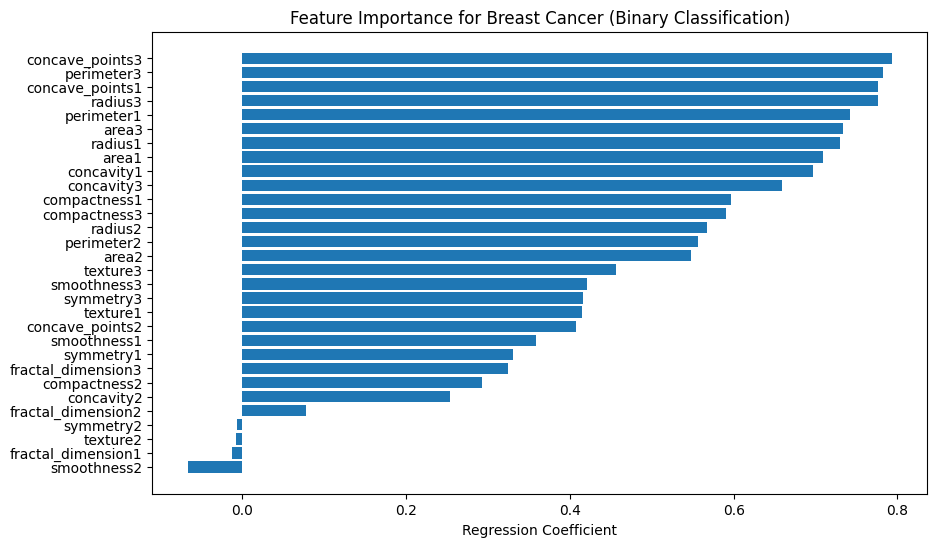

In [84]:
w_df = pd.DataFrame(bc_w_task1, index=bc_X.columns, columns=['Coefficient'])
w_df_sorted = w_df.sort_values(by='Coefficient', ascending=True)

# Plot horizontal barplot
plt.figure(figsize=(10, 6))
plt.barh(w_df_sorted.index, w_df_sorted['Coefficient'])
plt.xlabel('Regression Coefficient')
plt.title('Feature Importance for Breast Cancer (Binary Classification)')
plt.show()

# We can remove all features with negative coefficients
bc_X_cleaned = bc_X.drop(columns=['symmetry2', 'texture2', 'fractal_dimension1', 'smoothness2'])

## Breast cancer - Task 2 - Multiple Linear Regression

In [85]:
# Compute W
inverse = pd.DataFrame(np.linalg.inv(bc_X_cleaned.T @ bc_X_cleaned), index=bc_X_cleaned.columns, columns=bc_X_cleaned.columns)
bc_w_task2 = inverse @ bc_X_cleaned.T @ bc_y_scaled
bc_w_task2 = bc_w_task2.rename(columns={'Diagnosis': 'Coefficient'})
print("Matrix W using calculation :\n", bc_w_task2, "\n")

model = LinearRegression(add_bias=False)
model.fit(bc_X_cleaned.values, bc_y_scaled.values)
print("Matrix W using LR class :\n", model.w, "\n")

print("We get same the results for W both ways\n")

Matrix W using calculation :
                     Coefficient
radius1               -1.327493
texture1               0.073769
perimeter1             0.940480
area1                  0.289046
smoothness1           -0.027132
compactness1          -0.457516
concavity1             0.275809
concave_points1        0.191160
symmetry1             -0.000379
radius2                0.320841
perimeter2            -0.103436
area2                 -0.133321
compactness2           0.066611
concavity2            -0.259879
concave_points2        0.172810
fractal_dimension2    -0.032832
radius3                1.743659
texture3               0.057083
perimeter3            -0.143938
area3                 -1.111746
smoothness3            0.123184
compactness3          -0.014502
concavity3             0.156670
concave_points3       -0.010747
symmetry3              0.096418
fractal_dimension3     0.141688 

Matrix W using LR class :
 [[-1.32749340e+00]
 [ 7.37687081e-02]
 [ 9.40480241e-01]
 [ 2.89045571e-01]
 

<ipython-input-79-669c92a6f818>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


## Breast cancer - Task 3 - Logistic Regression

In [86]:
def numerical_gradient(X, y, w, epsilon=1e-5):
    num_grad = np.zeros_like(w)
    perturb = np.zeros_like(w)

    for i in range(len(w)):
        perturb[i] = epsilon
        loss1 = cost_fn(X, y, w + perturb)
        loss2 = cost_fn(X, y, w - perturb)
        num_grad[i] = (loss1 - loss2) / (2 * epsilon)
        perturb[i] = 0

    return num_grad

def compare_gradients(X, y, model):
    if model.w.ndim == 1:
        model.w = model.w.reshape(-1, 1)

    if model.add_bias:
      X = np.column_stack([X, np.ones(X.shape[0])])
      analytical_grad = model.gradient(X, y)
    else :
      analytical_grad = model.gradient(X, y)

    numerical_grad = numerical_gradient(X, y, model.w)

    diff = np.linalg.norm(analytical_grad - numerical_grad) / (np.linalg.norm(analytical_grad) + np.linalg.norm(numerical_grad))
    print(f"Gradient Difference: {diff}")
    if diff < 1e-6:
        print("Gradient check passed\n")
    else:
        print("Gradient check failed\n")



Accuracy of model: 97.54%

Gradient Difference: 5.5481345606335725e-11
Gradient check passed



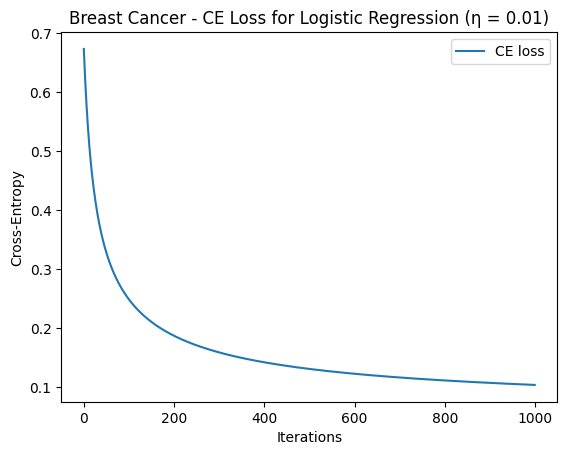

In [87]:
bc_LR_model = LogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1000, verbose=False)
ce, _ , validation_acc, bc_LR_X = bc_LR_model.fit(bc_X_cleaned.values, bc_y.values.reshape(-1, 1))
predictions = bc_LR_model.predict(bc_LR_X, use_best_w=False)
label_predictions = (predictions >= 0.5).astype(int)  # Convert to binary labels (0 or 1)
correct_predictions = (label_predictions == bc_y.values).astype(int)
accuracy = correct_predictions.sum() / len(bc_y)
print(f"\nAccuracy of model: {accuracy * 100:.2f}%\n")

compare_gradients(bc_X_cleaned.values, bc_y.values.reshape(-1, 1), bc_LR_model)

plt.plot(ce, label="CE loss")
plt.xlabel("Iterations")
plt.ylabel("Cross-Entropy")
plt.title("Breast Cancer - CE Loss for Logistic Regression (η = 0.01)")
plt.legend()
plt.show()

## Breast Cancer - Task 4 - Experiments

### Task 4.1

Ranked features from best to worst :                     Coefficient
concave_points3        0.793566
perimeter3             0.782914
concave_points1        0.776614
radius3                0.776454
perimeter1             0.742636
area3                  0.733825
radius1                0.730029
area1                  0.708984
concavity1             0.696360
concavity3             0.659610
compactness1           0.596534
compactness3           0.590998
radius2                0.567134
perimeter2             0.556141
area2                  0.548236
texture3               0.456903
smoothness3            0.421465
symmetry3              0.416294
texture1               0.415185
concave_points2        0.408042
smoothness1            0.358560
symmetry1              0.330499
fractal_dimension3     0.323872
compactness2           0.292999
concavity2             0.253730
fractal_dimension2     0.077972
symmetry2             -0.006522
texture2              -0.008303
fractal_dimension1    -0.012838
smo

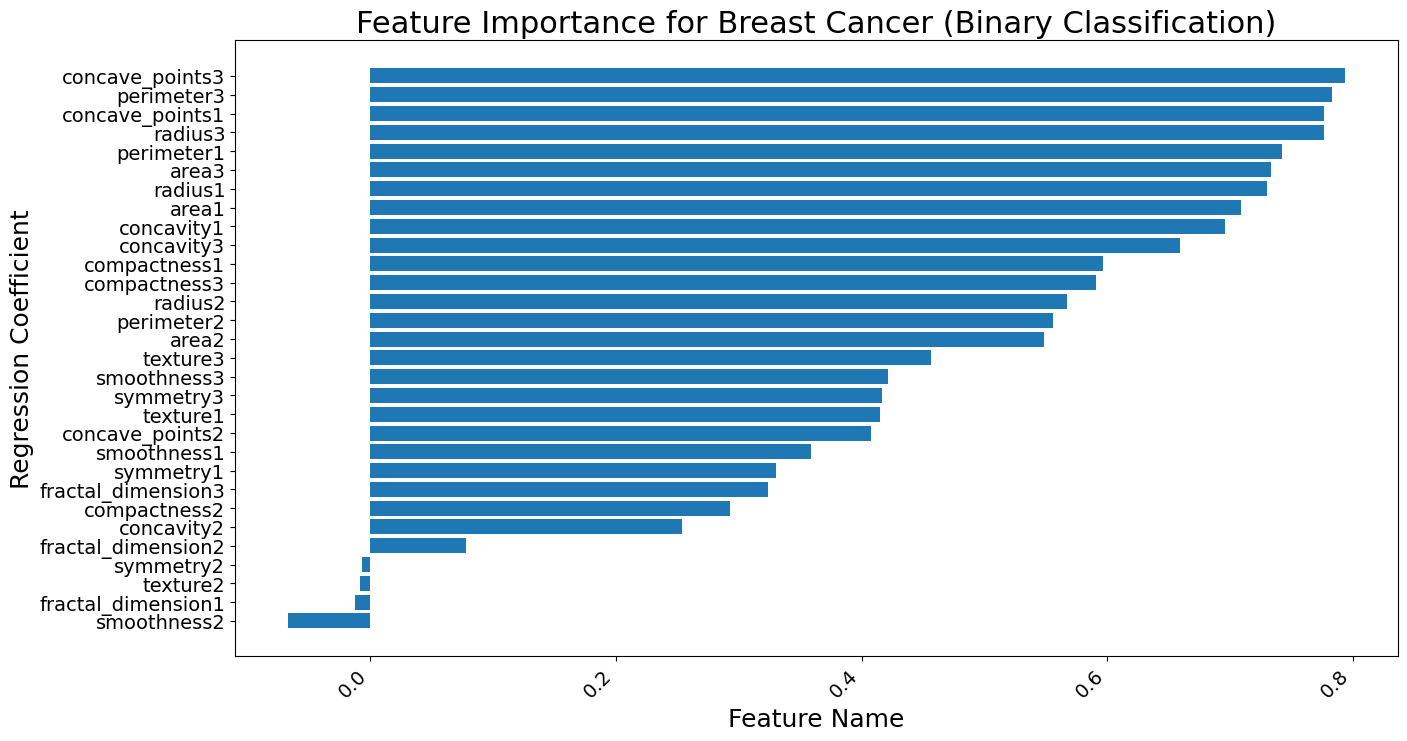

In [88]:
# Rank and barplot using simple linear regression
w_df = pd.DataFrame(bc_w_task1, index=bc_X.columns, columns=['Coefficient'])
w_df_sorted = w_df.sort_values(by='Coefficient', ascending=False)
print("Ranked features from best to worst :", w_df_sorted)
print()

w_df_sorted = w_df.sort_values(by='Coefficient', ascending=True)
# Plot horizontal barplot
plt.figure(figsize=(15, 8))
plt.barh(w_df_sorted.index, w_df_sorted['Coefficient'])
plt.xlabel('Feature Name', fontsize=18)
plt.ylabel('Regression Coefficient', fontsize=18)
plt.title('Feature Importance for Breast Cancer (Binary Classification)', fontsize=22)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Task 4.2 - 4.3

In [89]:
# Multiple Linear regression
print("Multiple Linear Regression:\n")
model = LinearRegression(add_bias=False)
model.fit(bc_X_cleaned.values, bc_y_scaled.values)
print("Matrix W using LR class :\n", model.w, "\n")

MLR_bc_yhat = model.predict(bc_X_cleaned.values)
MLR_bc_yhat = pd.DataFrame(MLR_bc_yhat, columns=['Diagnosis'])
MLR_bc_yhat = (MLR_bc_yhat >= 0).astype(int)  # Convert to binary labels (0 or 1)
print(MLR_bc_yhat)
correct_predictions = (MLR_bc_yhat.values == bc_y.values).astype(int)
MLR_bc_accuracy = correct_predictions.sum() / len(bc_y)
print(f"\nAccuracy of model: {MLR_bc_accuracy * 100:.2f}%\n")

Multiple Linear Regression:

Matrix W using LR class :
 [[-1.32749340e+00]
 [ 7.37687081e-02]
 [ 9.40480241e-01]
 [ 2.89045571e-01]
 [-2.71321314e-02]
 [-4.57516374e-01]
 [ 2.75809277e-01]
 [ 1.91159822e-01]
 [-3.78864493e-04]
 [ 3.20841479e-01]
 [-1.03435716e-01]
 [-1.33321070e-01]
 [ 6.66105208e-02]
 [-2.59879334e-01]
 [ 1.72809976e-01]
 [-3.28315944e-02]
 [ 1.74365897e+00]
 [ 5.70833397e-02]
 [-1.43938231e-01]
 [-1.11174578e+00]
 [ 1.23183911e-01]
 [-1.45023270e-02]
 [ 1.56669900e-01]
 [-1.07472590e-02]
 [ 9.64178109e-02]
 [ 1.41688462e-01]] 

     Diagnosis
0            1
1            1
2            1
3            1
4            1
..         ...
564          1
565          1
566          1
567          1
568          0

[569 rows x 1 columns]

Accuracy of model: 97.89%



<ipython-input-79-669c92a6f818>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


Binary logistic regression:


Accuracy of model: 97.54%

Gradient Difference: 5.5481345606335725e-11
Gradient check passed



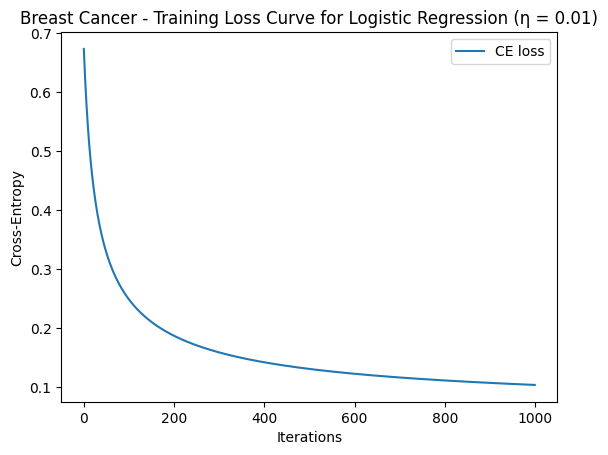

In [90]:
# Binary logistic regression
print("Binary logistic regression:\n")
BLR_model = LogisticRegression(add_bias=True, learning_rate=0.01, epsilon=1e-5, max_iters=1000, verbose=False)
ce, _, _, bc_BLR_X = BLR_model.fit(bc_X_cleaned.values, bc_y.values.reshape(-1, 1))
if BLR_model.verbose == False :
  #print("Matrix W for logistic regression :\n", BLR_model.w, "\n")
  print()
BLR_bc_yhat = BLR_model.predict(bc_BLR_X)
BLR_bc_yhat = pd.DataFrame(BLR_bc_yhat, columns=['Diagnosis'])
BLR_bc_yhat = (BLR_bc_yhat >= 0.5).astype(int)  # Convert to binary labels (0 or 1)
BLR_bc_accuracy = (BLR_bc_yhat.values == bc_y.values).astype(int).sum() / len(bc_y)
print(f"Accuracy of model: {BLR_bc_accuracy * 100:.2f}%\n")

compare_gradients(bc_X_cleaned.values, bc_y.values.reshape(-1, 1), BLR_model)

plt.plot(ce, label="CE loss")
plt.xlabel("Iterations")
plt.ylabel("Cross-Entropy")
plt.title("Breast Cancer - Training Loss Curve for Logistic Regression (η = 0.01)")
plt.legend()
plt.show()

### Task 4.4

Validation accuracy: 96.98%
Validation AUROC: 0.959

Test accuracy: 97.66%
Test AUROC: 0.968

Best iteration based on validation accuracy: 1997

Optimal number of iterations for CE loss: 4406



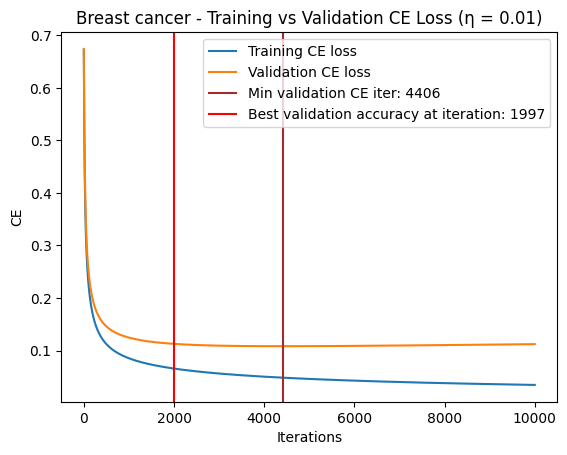

In [91]:
# Split into training, validation, and testing
bc_X_train, bc_X_test, bc_y_train, bc_y_test = train_test_split(
    bc_X_cleaned, bc_y, test_size = 0.3, random_state=1, shuffle=True)

# Split training set into training and testing
bc_X_train, bc_X_valid, bc_y_train, bc_y_valid = train_test_split(
   bc_X_train, bc_y_train, test_size = 0.5, random_state=1, shuffle=True)

scaler = StandardScaler()
bc_X_train = scaler.fit_transform(bc_X_train)
bc_X_valid = scaler.transform(bc_X_valid)
bc_X_test = scaler.transform(bc_X_test)

BLR_training_model = LogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=10000, verbose=False)
ce_train, ce_val, val_accuracies, _ = BLR_training_model.fit(bc_X_train, bc_y_train.values.reshape(-1, 1), bc_X_valid, bc_y_valid.values.reshape(-1, 1))

validation_prediction = BLR_training_model.predict(bc_X_valid, use_best_w=True)
validation_prediction = (validation_prediction >= 0.5).astype(int)
acc_valid = accuracy_score(bc_y_valid, validation_prediction)
roc_auc_valid = roc_auc_score(bc_y_valid, validation_prediction)
print(f"Validation accuracy: {acc_valid * 100:.2f}%")
print(f"Validation AUROC: {roc_auc_valid:.3f}\n")

test_prediction = BLR_training_model.predict(bc_X_test, use_best_w=True)
test_prediction = (test_prediction >= 0.5).astype(int)
acc_test = accuracy_score(bc_y_test, test_prediction)
bc_BLR_roc_auc_test = roc_auc_score(bc_y_test, test_prediction)
print(f"Test accuracy: {acc_test * 100:.2f}%")
print(f"Test AUROC: {bc_BLR_roc_auc_test:.3f}\n")


best_iteration = np.argmax(val_accuracies)
print(f"Best iteration based on validation accuracy: {best_iteration}\n")

optimal_iter = np.argmin(ce_val)
print(f"Optimal number of iterations for CE loss: {optimal_iter}\n")

plt.plot(ce_train , label='Training CE loss')
plt.plot(ce_val , label='Validation CE loss')
plt.axvline(x=optimal_iter, label=f"Min validation CE iter: {optimal_iter}", color="brown")
plt.axvline(x=best_iteration, label=f"Best validation accuracy at iteration: {best_iteration}", color='r')
plt.legend()
plt.xlabel("Iterations")
plt.title("Breast cancer - Training vs Validation CE Loss (η = 0.01)")
plt.ylabel("CE")
plt.show()

### Task 4.5

In [92]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Simple Linear Regression - Sigmoid
print("Simple Linear Regression:")
bc_w_task1_cleaned = bc_w_task1[~bc_w_task1.index.isin(['symmetry2', 'texture2', 'fractal_dimension1', 'smoothness2'])]
SLR_bc_yhat = bc_X_test @ bc_w_task1_cleaned
SLR_bc_yhat = sigmoid(SLR_bc_yhat)
SLR_bc_yhat = (SLR_bc_yhat >= 0.5).astype(int)

correct_predictions = (SLR_bc_yhat.values == bc_y_test.values).astype(int)

SLR_bc_accuracy = correct_predictions.sum() / len(bc_y_test)
SLR_bc_auroc = roc_auc_score(bc_y_test, SLR_bc_yhat)
print(f"Accuracy of model: {SLR_bc_accuracy * 100:.2f}%")
print(f"AUROC of model: {SLR_bc_auroc:.2f}\n")


# Multiple Linear Regression
print("Multiple Linear Regression:")
MLR_bc_yhat = bc_X_test @ bc_w_task2
MLR_bc_yhat = sigmoid(MLR_bc_yhat.values)
MLR_bc_yhat = pd.DataFrame(MLR_bc_yhat, columns=['Diagnosis'])
MLR_bc_yhat = (MLR_bc_yhat >= 0.5).astype(int)
MLR_bc_accuracy = (MLR_bc_yhat.values == bc_y_test.values).astype(int).sum() / len(bc_y_test)
MLR_bc_auroc = roc_auc_score(bc_y_test, MLR_bc_yhat)
print(f"Accuracy of model: {MLR_bc_accuracy * 100:.2f}%")
print(f"AUROC of model: {MLR_bc_auroc:.2f}\n")


# Binary Logistic Regression
print("Binary Logistic Regression:")
acc_test = accuracy_score(bc_y_test, test_prediction)
bc_BLR_roc_auc_test = roc_auc_score(bc_y_test, test_prediction)
print(f"Test accuracy: {acc_test*100:.2f}%")
print(f"Test AUROC: {bc_BLR_roc_auc_test:.2f}\n")

Simple Linear Regression:
Accuracy of model: 92.40%
AUROC of model: 0.92

Multiple Linear Regression:
Accuracy of model: 97.08%
AUROC of model: 0.97

Binary Logistic Regression:
Test accuracy: 97.66%
Test AUROC: 0.97



### Task 4.6

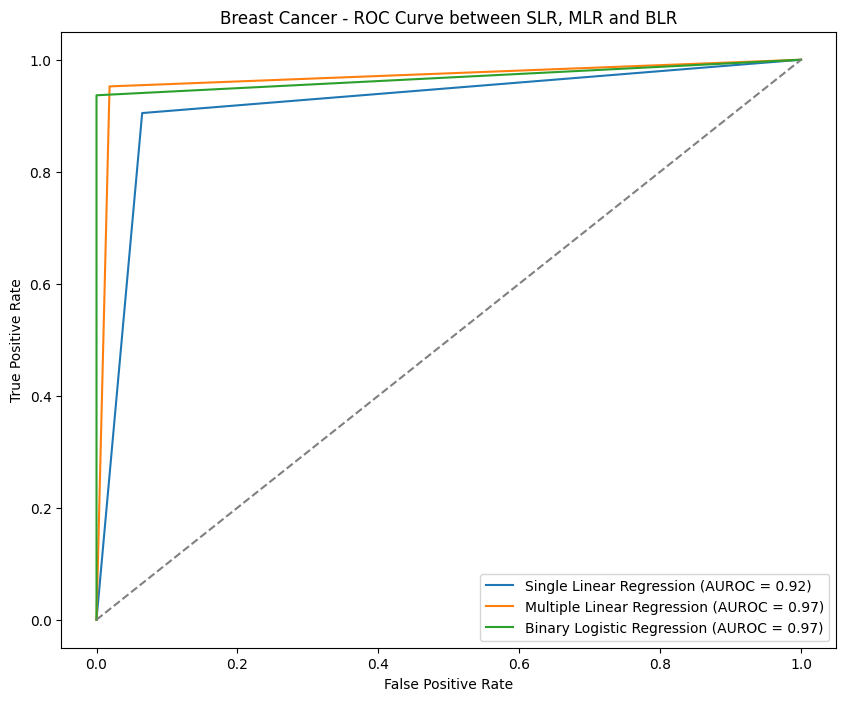

In [93]:
fpr_SLR, tpr_SLR, _ = roc_curve(bc_y_test, SLR_bc_yhat)
fpr_MLR, tpr_MLR, _ = roc_curve(bc_y_test, MLR_bc_yhat)
fpr_BLR, tpr_BLR, _ = roc_curve(bc_y_test, test_prediction)

plt.figure(figsize=(10, 8))
plt.plot(fpr_SLR, tpr_SLR, label=f'Single Linear Regression (AUROC = {SLR_bc_auroc:.2f})')
plt.plot(fpr_MLR, tpr_MLR, label=f'Multiple Linear Regression (AUROC = {MLR_bc_auroc:.2f})')
plt.plot(fpr_BLR, tpr_BLR, label=f'Binary Logistic Regression (AUROC = {bc_BLR_roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Breast Cancer - ROC Curve between SLR, MLR and BLR')
plt.legend(loc='best')
plt.show()

### Task 4.8

Simple Linear Regression: (30, 1)
                    Coefficient
concave_points3        0.793566
perimeter3             0.782914
concave_points1        0.776614
radius3                0.776454
perimeter1             0.742636
area3                  0.733825
radius1                0.730029
area1                  0.708984
concavity1             0.696360
concavity3             0.659610
compactness1           0.596534
compactness3           0.590998
radius2                0.567134
perimeter2             0.556141
area2                  0.548236
texture3               0.456903
smoothness3            0.421465
symmetry3              0.416294
texture1               0.415185
concave_points2        0.408042
smoothness1            0.358560
symmetry1              0.330499
fractal_dimension3     0.323872
compactness2           0.292999
concavity2             0.253730
fractal_dimension2     0.077972

Multiple Linear Regression: (26, 1)
                    Coefficient
radius3                1.743659
p

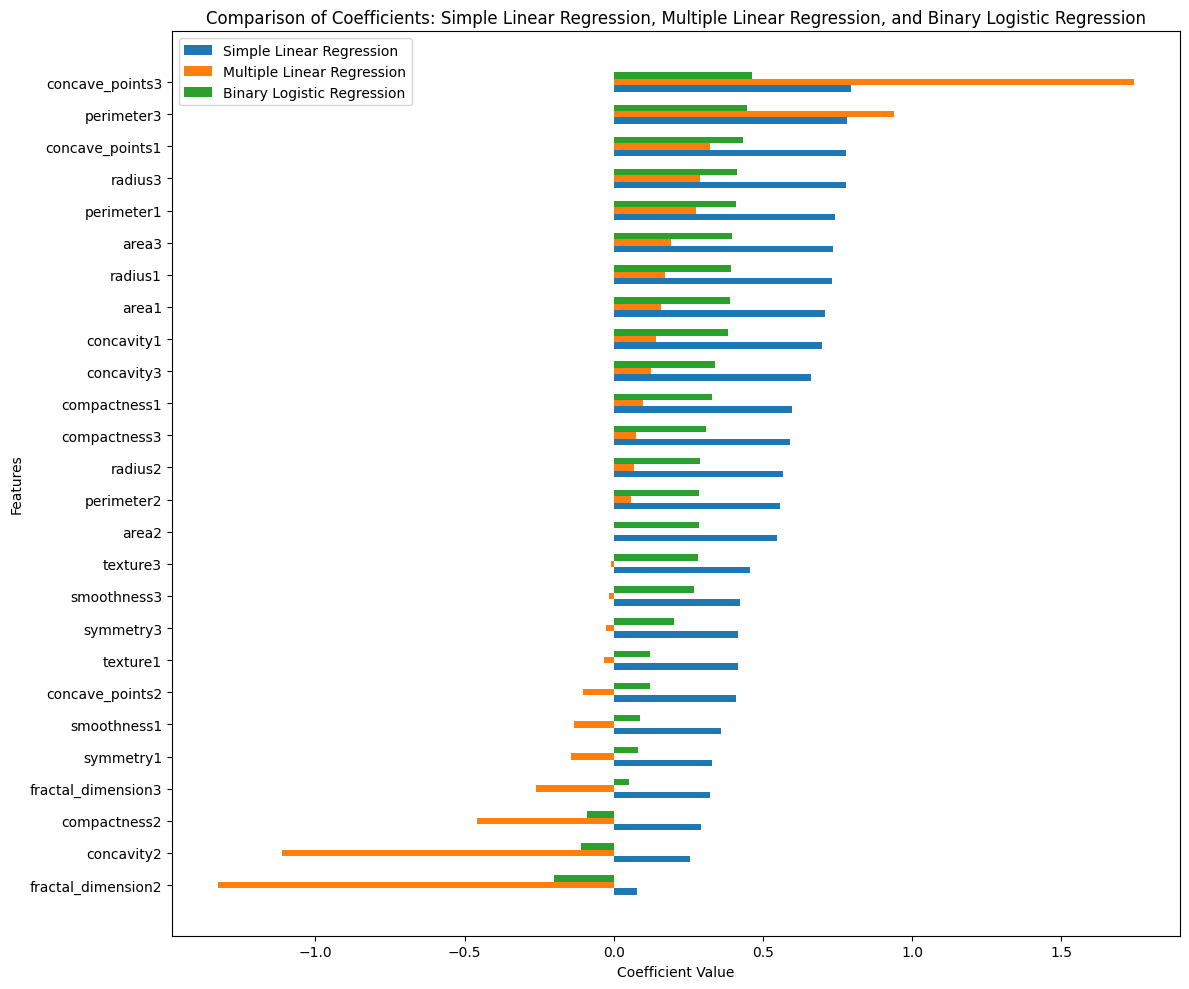

In [129]:
rows_to_remove = ['symmetry2', 'texture2', 'fractal_dimension1', 'smoothness2']

# Simple Linear Regression
print("Simple Linear Regression:", bc_w_task1.shape)
sorted_bc_w_task1 = bc_w_task1.sort_values(by=["Coefficient"], ascending=False)
sorted_bc_w_task1 = sorted_bc_w_task1[~sorted_bc_w_task1.index.isin(rows_to_remove)]
print(sorted_bc_w_task1)

# Multiple Linear Regression
print(f"\nMultiple Linear Regression:", bc_w_task2.shape)
sorted_bc_w_task2 = bc_w_task2.sort_values(by=["Coefficient"], ascending=False)
print(sorted_bc_w_task2)

# Binary Logistic Regression
print(f"\nBinary Logistic Regression:", BLR_model.w.shape)
indexes = list(bc_w_task2.index)
indexes.append("bias")
BLR_model_w = pd.DataFrame(BLR_model.w, index=indexes, columns=["Coefficient"])
BLR_model_w = BLR_model_w[~BLR_model_w.index.isin(['bias'])]
sorted_BLR_model_w = BLR_model_w.sort_values(by="Coefficient", ascending=False)
print(sorted_BLR_model_w)


sorted_bc_w_task1 = sorted_bc_w_task1.sort_values(by=["Coefficient"], ascending=True)
sorted_bc_w_task2 = sorted_bc_w_task2.sort_values(by=["Coefficient"], ascending=True)
sorted_BLR_model_w = sorted_BLR_model_w.sort_values(by=["Coefficient"], ascending=True)

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 10))
bar_height = 0.4
index = np.arange(len(sorted_bc_w_task1)) * 2
ax.barh(index - bar_height, sorted_bc_w_task1["Coefficient"].values, bar_height, label='Simple Linear Regression')
ax.barh(index, sorted_bc_w_task2["Coefficient"].values, bar_height, label='Multiple Linear Regression')
ax.barh(index + bar_height, sorted_BLR_model_w["Coefficient"].values, bar_height, label='Binary Logistic Regression')

ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Comparison of Coefficients: Simple Linear Regression, Multiple Linear Regression, and Binary Logistic Regression')

ax.set_yticks(index)
ax.set_yticklabels(sorted_bc_w_task1.index)

ax.legend()
plt.tight_layout()
plt.show()


# Penguin Dataset (Multiclass classification)

## Penguin - Task 1 - Simple Linear Regression

In [95]:
penguin_df = pd.read_csv('/content/drive/My Drive/COMP 551/Assignment 1/penguins_size.csv', index_col = 0)
penguin_df = penguin_df.reset_index()
penguin_df = penguin_df.dropna()
penguin_df = penguin_df.drop(columns = ['island', 'sex'])

penguin_X = penguin_df.drop(columns = ['species'])
penguin_Y = penguin_df['species'].copy()
penguin_Y_non_encoded = penguin_Y.copy()
penguin_Y_non_encoded = penguin_Y_non_encoded.replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})
penguin_Y = penguin_Y.replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})
penguin_Y = pd.get_dummies(penguin_Y)

# Standardize labels to fit with linear regression
scaler_penguin_y = StandardScaler()
Y_scaled = scaler_penguin_y.fit_transform(penguin_Y)
penguin_Y_scaled = pd.DataFrame(Y_scaled, columns=penguin_Y.columns)

# Standardize features
scaler_penguin = StandardScaler()
X_scaled = scaler_penguin.fit_transform(penguin_X)
penguin_X = pd.DataFrame(X_scaled, columns=penguin_X.columns)

# Compute w for linear regression
penguin_W_task1 = (penguin_X.T.values @ penguin_Y_scaled.values) / penguin_X.shape[0]
for j in range(penguin_W_task1.shape[1]):  # Iterate over classes (columns of W)
    if j == 0:
        name = 'Adelie'
    elif j == 1:
        name = 'Chinstrap'
    else:
      name = 'Gentoo'
    print(f"Class {name}:")
    for i, feature in enumerate(penguin_X.columns):  # Iterate over features (rows of W)
        print(f"  Feature: {feature}: {penguin_W_task1[i, j]:.6f}")
    print()

Class Adelie:
  Feature: culmen_length_mm: -0.835667
  Feature: culmen_depth_mm: 0.532248
  Feature: flipper_length_mm: -0.686826
  Feature: body_mass_g: -0.551463

Class Chinstrap:
  Feature: culmen_length_mm: 0.448779
  Feature: culmen_depth_mm: 0.324241
  Feature: flipper_length_mm: -0.187472
  Feature: body_mass_g: -0.299458

Class Gentoo:
  Feature: culmen_length_mm: 0.487312
  Feature: culmen_depth_mm: -0.822388
  Feature: flipper_length_mm: 0.867414
  Feature: body_mass_g: 0.821454



<ipython-input-95-ee8969c93192>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguin_Y_non_encoded = penguin_Y_non_encoded.replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})
<ipython-input-95-ee8969c93192>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguin_Y = penguin_Y.replace({'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2})


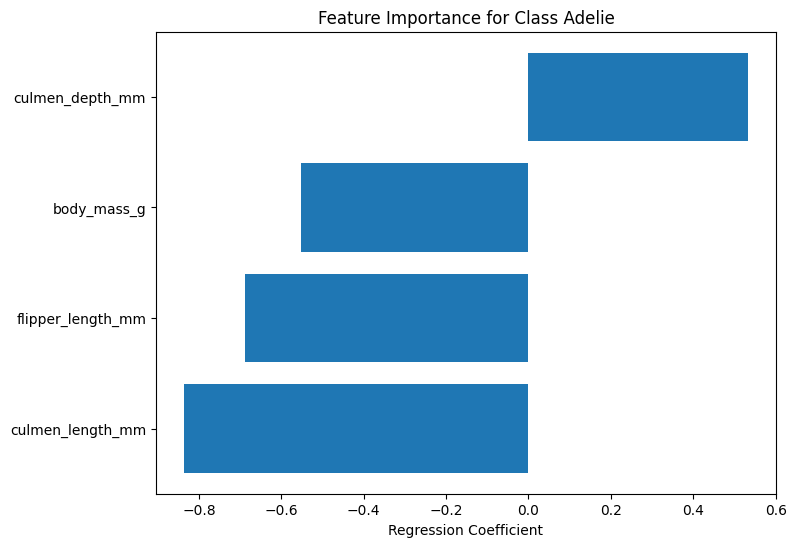

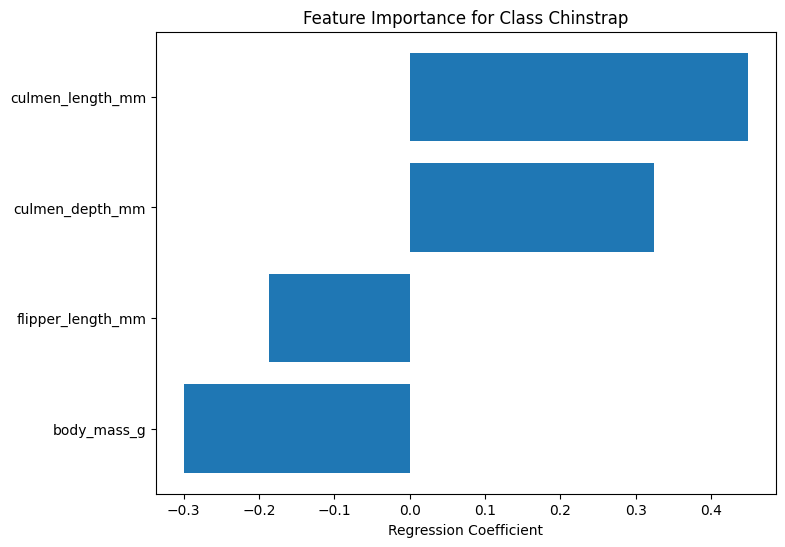

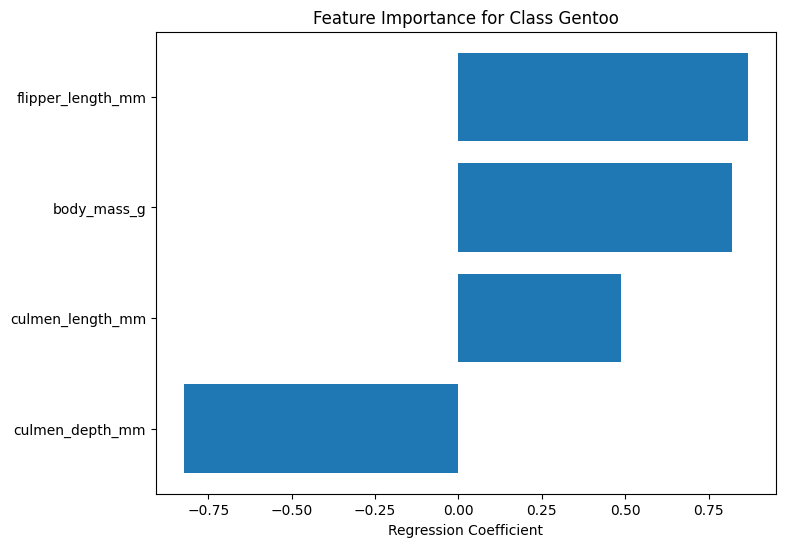

In [96]:
feature_names = penguin_X.columns
for class_idx in range(penguin_W_task1.shape[1]):
    coefficients = penguin_W_task1[:, class_idx]
    feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].sort_values(ascending=True).index)

    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance.index, feature_importance['Coefficient'])
    plt.xlabel('Regression Coefficient')
    if class_idx == 0:
        plt.title('Feature Importance for Class Adelie')
    elif class_idx == 1:
        plt.title('Feature Importance for Class Chinstrap')
    else:
      plt.title(f'Feature Importance for Class Gentoo')
    plt.show()

# From the plots, we can see that all features are required so we don't remove anything.

## Penguin - Task 2 - Multiple Linear Regression

In [97]:
# Computing W for penguin dataset
inverse = pd.DataFrame(np.linalg.inv(penguin_X.T @ penguin_X), index=penguin_X.columns, columns=penguin_X.columns)
penguin_W_task2 = inverse @ penguin_X.T.values @ penguin_Y_scaled.values
print("Matrix W using calculations:")
print(penguin_W_task2, "\n")

penguin_Y_prediction = penguin_X @ penguin_W_task2

# Predicting best label for a datapoint
penguin_Y_prediction = np.argmax(penguin_Y_prediction.values, axis=1)
penguin_Y_prediction = pd.DataFrame(penguin_Y_prediction, columns=['Predicted Label'])
print(penguin_Y_prediction)

# Step 5: Convert the one-hot encoded true labels to class indices (for comparison)
penguin_Y_class = penguin_Y.idxmax(axis=1)
correct_predictions = (penguin_Y_prediction['Predicted Label'].values == penguin_Y_class.values).astype(int)
accuracy = correct_predictions.sum() / len(penguin_Y_class)
print(f"\nAccuracy: {accuracy * 100:.2f}%\n")

# Using the Linear Regression class
model = LinearRegression(add_bias=False)
model.fit(penguin_X.values, penguin_Y_scaled.values)
print("Matrix W using LR class :\n", model.w, "\n")

print("We get the same results both ways\n")

Matrix W using calculations:
                          0         1         2
culmen_length_mm  -0.776811  0.980855 -0.020088
culmen_depth_mm    0.365795  0.137668 -0.493717
flipper_length_mm -0.158579 -0.161172  0.299212
body_mass_g        0.217619 -0.671394  0.338490 

     Predicted Label
0                  0
1                  0
2                  0
3                  0
4                  0
..               ...
329                2
330                2
331                2
332                2
333                2

[334 rows x 1 columns]

Accuracy: 98.50%

Matrix W using LR class :
 [[-0.77681096  0.98085512 -0.02008823]
 [ 0.36579501  0.13766785 -0.49371689]
 [-0.15857859 -0.16117219  0.29921235]
 [ 0.21761904 -0.671394    0.33849013]] 

We get the same results both ways



<ipython-input-79-669c92a6f818>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


## Penguin - Task 3 - Multinomial Logistic Regression

In [98]:
def numerical_gradient(X, y, model, epsilon=1e-5):
    num_grad = np.zeros_like(model.W)

    for i in range(model.W.shape[0]):
        for j in range(model.W.shape[1]):
            perturb = np.zeros_like(model.W)
            perturb[i, j] = epsilon

            model.W += perturb
            loss1 = model.ce(X, y)
            model.W -= 2 * perturb
            loss2 = model.ce(X, y)
            model.W += perturb

            num_grad[i, j] = (loss1 - loss2) / (2 * epsilon)

    return num_grad

def compare_gradients(X, y, model):
    analytical_grad = model.gradient(X, y)
    numerical_grad = numerical_gradient(X, y, model)
    diff = np.linalg.norm(analytical_grad - numerical_grad) / (np.linalg.norm(analytical_grad) + np.linalg.norm(numerical_grad))
    print(f"Gradient Difference: {diff}")

    if diff < 1e-6:
        print("Gradient check passed\n")
    else:
        print("Gradient check failed\n")


Accuracy of model : 99.70%

Comparing gradients using personal implementation:
Gradient Difference: 9.642840750367045e-09
Gradient check passed


Comparing gradients using model implementation: 1.2967275822317964e-14 



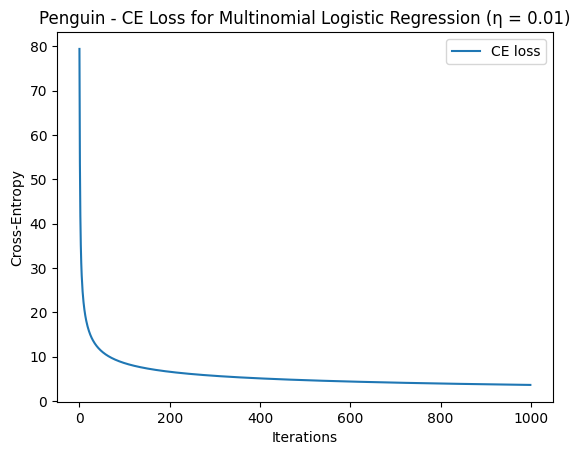

In [99]:
penguin_MNLR_model = Multinomial_logistic(penguin_X.shape[1], penguin_Y.shape[1], verbose=False)
ce, _, _ = penguin_MNLR_model.fit(penguin_X.values, penguin_Y.values, lr=0.01, niter=1000)

penguin_Y_prediction = penguin_MNLR_model.predict(penguin_X.values)
penguin_Y_prediction = np.argmax(penguin_Y_prediction, axis=1)
penguin_Y_prediction = pd.DataFrame(penguin_Y_prediction, columns=['Predicted Label'])
penguin_Y_class = penguin_Y.idxmax(axis=1)
correct_predictions = (penguin_Y_prediction['Predicted Label'].values == penguin_Y_class.values).astype(int)
accuracy = correct_predictions.sum() / len(penguin_Y_class)
print(f"\nAccuracy of model : {accuracy * 100:.2f}%\n")

print("Comparing gradients using personal implementation:")
compare_gradients(penguin_X.values, penguin_Y.values, penguin_MNLR_model)

print("\nComparing gradients using model implementation:", penguin_MNLR_model.check_grad(penguin_X.values, penguin_Y.values), "\n")

plt.plot(ce, label='CE loss')
plt.xlabel("Iterations")
plt.ylabel("Cross-Entropy")
plt.title("Training Loss Curve")
plt.legend()
plt.title("Penguin - CE Loss for Multinomial Logistic Regression (η = 0.01)")
plt.show()

## Penguin - Task 4 - Experiments

### Task 4.1

Regression Coefficients Matrix W:
 [[-0.83566748  0.44877868  0.48731237]
 [ 0.53224817  0.32424092 -0.82238837]
 [-0.68682605 -0.18747237  0.86741412]
 [-0.55146292 -0.29945781  0.82145403]]

Ranked Features for Class Adelie:
                   Coefficient
culmen_depth_mm       0.532248
body_mass_g          -0.551463
flipper_length_mm    -0.686826
culmen_length_mm     -0.835667


Ranked Features for Class Chinstrap:
                   Coefficient
culmen_length_mm      0.448779
culmen_depth_mm       0.324241
flipper_length_mm    -0.187472
body_mass_g          -0.299458


Ranked Features for Class Gentoo:
                   Coefficient
flipper_length_mm     0.867414
body_mass_g           0.821454
culmen_length_mm      0.487312
culmen_depth_mm      -0.822388



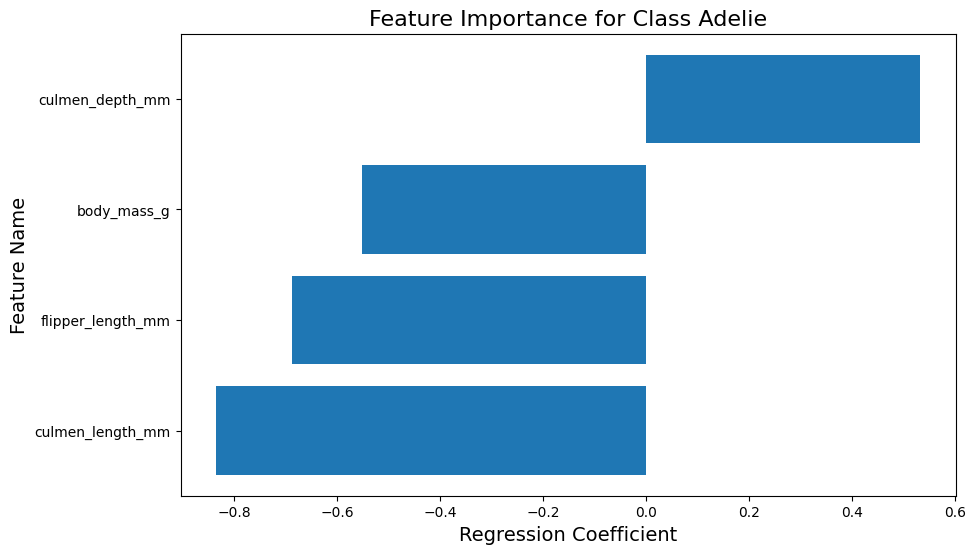

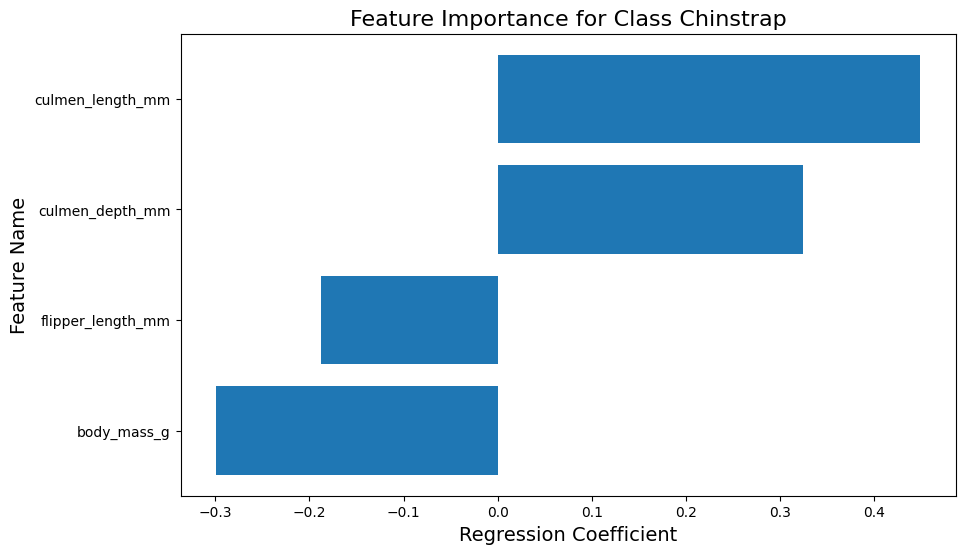

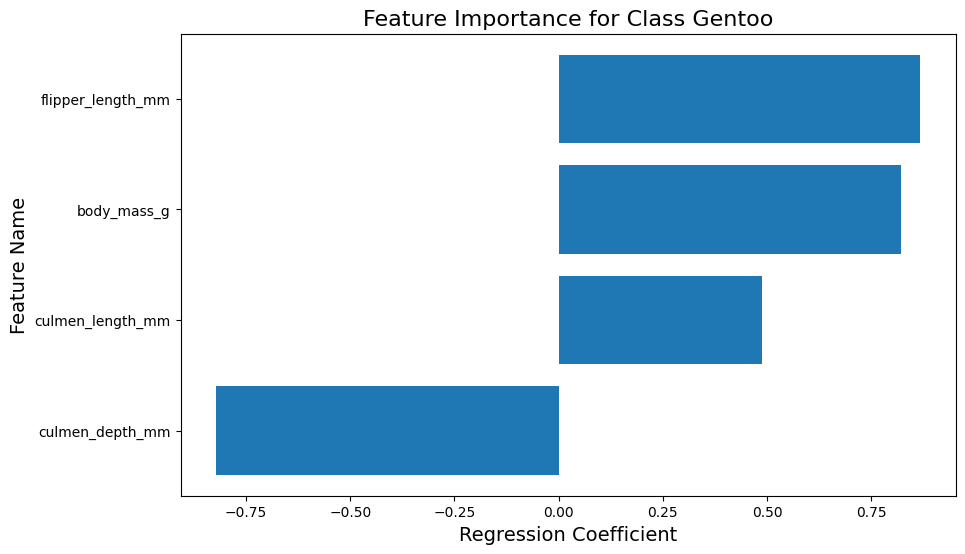

In [100]:
feature_names = penguin_X.columns
print("Regression Coefficients Matrix W:\n", penguin_W_task1)

class_labels = ['Adelie', 'Chinstrap', 'Gentoo']

for class_idx in range(penguin_W_task1.shape[1]):
    coefficients = penguin_W_task1[:, class_idx]
    feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])
    feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
    print(f"\nRanked Features for Class {class_labels[class_idx]}:")
    print(feature_importance)
    print()

for class_idx in range(penguin_W_task1.shape[1]):
    coefficients = penguin_W_task1[:, class_idx]
    feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])
    feature_importance = feature_importance.sort_values(by='Coefficient', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.index, feature_importance['Coefficient'])
    plt.xlabel('Regression Coefficient', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14)
    plt.title(f'Feature Importance for Class {class_labels[class_idx]}', fontsize=16)
    plt.show()
    print("\n")

### Task 4.2 - 4.3

In [101]:
# Multivariate Linear Regression
print("Multivariate Linear Regression:\n")
W = np.linalg.inv(penguin_X.T @ penguin_X) @ penguin_X.T @ penguin_Y_scaled
print("Matrix W using calculations :\n", W, "\n")
MVLR_penguin_yhat = penguin_X.values @ W
print("Predicted Values :\n", MVLR_penguin_yhat, "\n")
MVLR_penguin_yhat = np.argmax(MVLR_penguin_yhat.values, axis=1)
MVLR_penguin_yhat = pd.DataFrame(MVLR_penguin_yhat, columns=['Predicted Label'])
MVLR_penguin_accuracy = (MVLR_penguin_yhat['Predicted Label'].values == penguin_Y_non_encoded).astype(int).sum() / len(penguin_Y_non_encoded)
print(f"Accuracy of model: {MVLR_penguin_accuracy * 100:.2f}%\n")

Multivariate Linear Regression:

Matrix W using calculations :
           0         1         2
0 -0.776811  0.980855 -0.020088
1  0.365795  0.137668 -0.493717
2 -0.158579 -0.161172  0.299212
3  0.217619 -0.671394  0.338490 

Predicted Values :
             0         1         2
0    1.086284 -0.158688 -0.989874
1    0.744197 -0.277139 -0.536797
2    0.491042  0.264711 -0.729826
3    1.322762 -0.435903 -1.001702
4    1.282477 -0.009649 -1.317791
..        ...       ...       ...
329 -1.054119 -0.413365  1.436723
330 -0.917070 -0.392140  1.277221
331 -1.004917 -0.478913  1.440868
332 -0.467277 -0.902817  1.240795
333 -0.852061 -0.144827  1.002451

[334 rows x 3 columns] 

Accuracy of model: 98.50%



In [102]:
# Multi-class Logistic Regression
print("Multi-class Logistic Regression:\n")
MNLR_model = Multinomial_logistic(penguin_X.shape[1], penguin_Y_scaled.shape[1], verbose=False)
MNLR_model.fit(penguin_X.values, penguin_Y.values, niter=100)
MNLR_penguin_yhat = MNLR_model.predict(penguin_X.values)
MNLR_penguin_yhat = np.argmax(MNLR_penguin_yhat, axis=1)
MNLR_penguin_yhat = pd.DataFrame(MNLR_penguin_yhat, columns=['Predicted Label'])
MNLR_penguin_accuracy = (MNLR_penguin_yhat['Predicted Label'].values == penguin_Y_non_encoded).astype(int).sum() / len(penguin_Y_non_encoded)
print(f"Accuracy of model: {MNLR_penguin_accuracy * 100:.2f}%\n")

print("Comparing gradients using personal implementation:")
compare_gradients(penguin_X.values, penguin_Y.values, MNLR_model)
print(MNLR_model.best_W)
print("\nComparing gradients using model implementation:", MNLR_model.check_grad(penguin_X.values, penguin_Y.values), "\n")

Multi-class Logistic Regression:

Accuracy of model: 99.10%

Comparing gradients using personal implementation:
Gradient Difference: 9.975798920256733e-09
Gradient check passed

None

Comparing gradients using model implementation: 1.0500790727905958e-11 



### Task 4.4

Best iteration based on validation accuracy: 7694

Validation accuracy: 100.00%
Validation AUROC: 1.000

Test accuracy: 100.00%
Test AUROC: 1.000



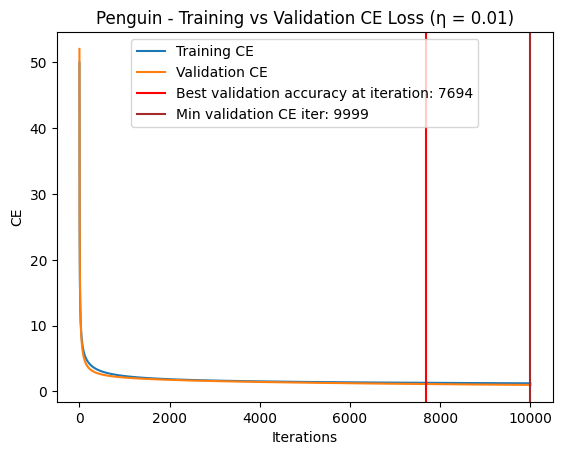

In [103]:
# Multinomial Logistic

# Split into training and testing
penguin_X_train, penguin_X_test, penguin_Y_train, penguin_Y_test = train_test_split(
    penguin_X, penguin_Y, test_size = 0.33, random_state=1, shuffle=True)

# Split training set into training and testing
penguin_X_train, penguin_X_valid, penguin_Y_train, penguin_Y_valid = train_test_split(
    penguin_X_train, penguin_Y_train, test_size = 0.5, random_state=1, shuffle=True)

penguin_training_model = Multinomial_logistic(penguin_X_train.shape[1], penguin_Y_train.shape[1], verbose=False)
ce_train, ce_valid, val_accuracies = penguin_training_model.fit(penguin_X_train.values, penguin_Y_train.values, penguin_X_valid.values, penguin_Y_valid.values, lr=0.01, niter=10000)

valid_prediction = penguin_training_model.predict(penguin_X_valid.values, use_best_w=True)
test_prediction = penguin_training_model.predict(penguin_X_test.values, use_best_w=True)

valid_accuracy = penguin_training_model.evaluate(valid_prediction, penguin_Y_valid)
test_accuracy = penguin_training_model.evaluate(test_prediction, penguin_Y_test)

best_iteration = np.argmax(val_accuracies)
print(f"Best iteration based on validation accuracy: {best_iteration}\n")

print(f"Validation accuracy: {valid_accuracy*100:.2f}%")
valid_auroc = roc_auc_score(penguin_Y_valid, valid_prediction, average='macro', multi_class='ovr')
print(f"Validation AUROC: {valid_auroc:.3f}\n")

print(f"Test accuracy: {test_accuracy * 100:.2f}%")
test_auroc = roc_auc_score(penguin_Y_test, test_prediction, average='macro', multi_class='ovr')
print(f"Test AUROC: {test_auroc:.3f}\n")

optimal_niter = ce_valid.argmin()
plt.plot(ce_train, label='Training CE')
plt.plot(ce_valid, label='Validation CE')
plt.axvline(x=best_iteration, label=f"Best validation accuracy at iteration: {best_iteration}", color='r')
plt.axvline(x=optimal_niter, label=f"Min validation CE iter: {optimal_niter}", color="brown")
plt.legend()
plt.xlabel("Iterations")
plt.title("Penguin - Training vs Validation CE Loss (η = 0.01)")
plt.ylabel("CE")
plt.show()

### Task 4.5

In [104]:
def softmax(z):
    z = np.array(z)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

penguin_Y_test_class = penguin_Y_test.idxmax(axis=1)

# Simple Linear Regression - Softmax
print("Simple Linear Regression:")
penguin_SLR_yhat = penguin_X_test @ penguin_W_task1
penguin_SLR_yhat_probs = softmax(penguin_SLR_yhat)
penguin_SLR_yhat = np.argmax(penguin_SLR_yhat_probs, axis=1)

penguin_SLR_accuracy = (penguin_SLR_yhat == penguin_Y_test_class).astype(int).sum() / len(penguin_Y_test_class)
print(f"SLR accuracy: {penguin_SLR_accuracy * 100:.2f}%\n")


# Multiple Linear Regression
print("Multiple Linear Regression:")
model = LinearRegression(add_bias=True)
model.fit(penguin_X_train.values, penguin_Y_train.values)

penguin_MLR_yhat = model.predict(penguin_X_test.values)
penguin_MLR_yhat_probs = softmax(penguin_MLR_yhat)
penguin_MLR_yhat = np.argmax(penguin_MLR_yhat, axis=1)
penguin_MLR_yhat = pd.DataFrame(penguin_MLR_yhat, columns=['Predicted Label'])

penguin_MLR_accuracy = (penguin_MLR_yhat['Predicted Label'].values == penguin_Y_test_class).astype(int).sum() / len(penguin_Y_test)
penguin_MLR_auroc = roc_auc_score(penguin_Y_test.to_numpy(), penguin_MLR_yhat_probs, multi_class='ovr', average='macro')
print(f"MLR accuracy: {penguin_MLR_accuracy * 100:.2f}%\n")


# Logistic Regression
print("Multi-Class Logistic Regression:")
print(f"MCLR Test accuracy: {test_accuracy*100:.2f}%\n")

Simple Linear Regression:
SLR accuracy: 93.69%

Multiple Linear Regression:
MLR accuracy: 100.00%

Multi-Class Logistic Regression:
MCLR Test accuracy: 100.00%



<ipython-input-79-669c92a6f818>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference


### Task 4.7

In [105]:
# MVLR - Computed previously (Task 4.2)
print("Multivariate Linear Regression:")
print(f"Multivariate Linear Regression (Task 4.2) Test accuracy: {penguin_MLR_accuracy * 100:.2f}%\n")

# MCLR - Computed previously (Task 4.4)
print("Logistic Regression:")
print(f"Multiclass Logistic Regression (Task 4.4) Test accuracy: {test_accuracy*100:.2f}%")

Multivariate Linear Regression:
Multivariate Linear Regression (Task 4.2) Test accuracy: 100.00%

Logistic Regression:
Multiclass Logistic Regression (Task 4.4) Test accuracy: 100.00%


### Task 4.9

In [106]:
class_label_mapping = {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
feature_label_mapping = {0: 'culmen_length_mm', 1: 'culmen_depth_mm', 2: 'flipper_length_mm', 3: 'body_mass_g'}


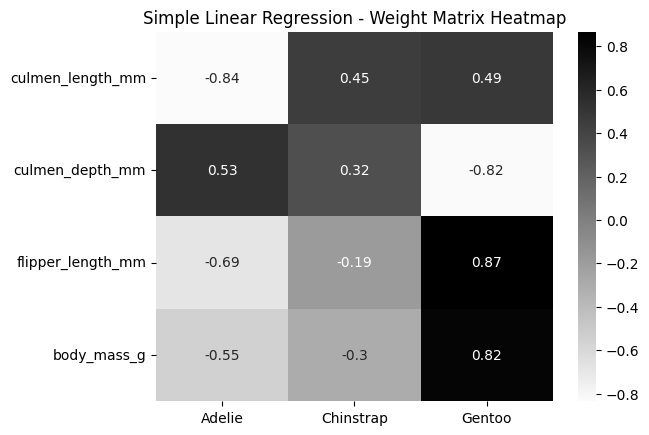

In [107]:
# Simple Linear Regression
W_hat1 = penguin_W_task1
W_hat1 = pd.DataFrame(W_hat1)
W_hat1 = W_hat1.rename(columns=class_label_mapping)
W_hat1 = W_hat1.rename(index=feature_label_mapping)

plt.title('Simple Linear Regression - Weight Matrix Heatmap')

hmp = sns.heatmap(W_hat1, cmap='gray_r', center=0, annot=True)
fig = hmp.get_figure()

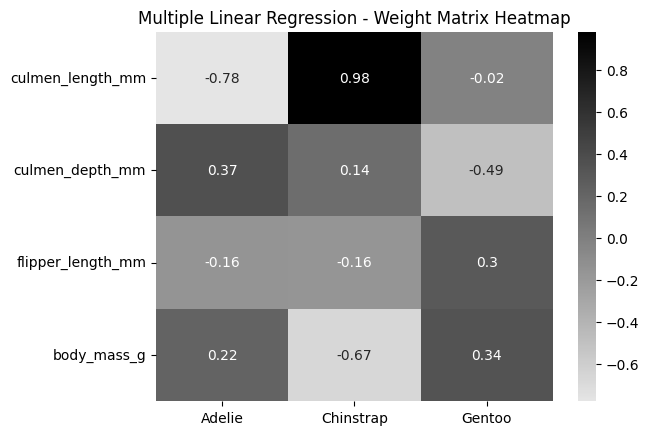

In [108]:
# Multiple Linear Regression
class_label_mapping = {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
W_hat2 = penguin_W_task2
W_hat2 = penguin_W_task2.rename(columns=class_label_mapping)
hmp2 = heatmap(W_hat2, cmap='gray_r', center=0, annot=True)
plt.title('Multiple Linear Regression - Weight Matrix Heatmap')
fig2 = hmp.get_figure()

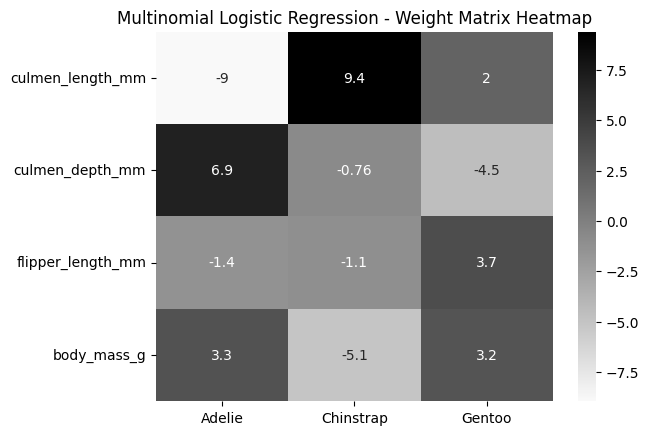

In [109]:
# Multinomial Logistic Regression
class_label_mapping = {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
feature_label_mapping = {0: 'culmen_length_mm', 1: 'culmen_depth_mm', 2: 'flipper_length_mm', 3: 'body_mass_g'}
W_hat3 = penguin_training_model.best_W
W_hat3 = pd.DataFrame(W_hat3)
W_hat3 = W_hat3.rename(columns=class_label_mapping)
W_hat3 = W_hat3.rename(index=feature_label_mapping)
plt.title('Multinomial Logistic Regression - Weight Matrix Heatmap')
hmp3 = heatmap(W_hat3, cmap='gray_r', center=0, annot=True)
fig3 = hmp.get_figure()